# DaKanjiRecognizer - Single Kanji CNN : Training

## Setup

Import the needed libraries.

In [1]:
#std lib
import sys
import os
import random
import math
import random
import multiprocessing as mp
import gc
import time
import datetime
from tqdm import tqdm

#reading the dataset
from etldr.etl_data_reader import ETLDataReader
from etldr.etl_character_groups import ETLCharacterGroups
from etldr.etl_data_names import ETLDataNames

#data handling
import PIL
from PIL import Image as PImage
from PIL import ImageFilter, ImageFont, ImageDraw
import numpy as np

#ML
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

#creating one hot encodings
from sklearn.preprocessing import LabelBinarizer

#plotting/showing graphics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
show_sample_font = fm.FontProperties(fname=os.path.join("..", "fonts", "NotoSerifCJKjp-Regular.otf"), size=20)

## Loading the data

The [ETL Character data set](http://etlcdb.db.aist.go.jp/) which I am using is a data set with multiple sub sets (ETL1 - ETL7, ETL8B, ETL8G, ETL9B and ETL9G). <br/>
After unpacking the data set I renamed all folders and files to have a uniform naming scheme: "ETLX/ETLX_Y". "X" is the number of the subset and Y the part of the subset. Also ETL7S was removed (ETL7L just smaller), the following renaming was also done: <br/>
ETL8B $\rightarrow$ ETL1, ETL8G $\rightarrow$ ETL9, ETL9B $\rightarrow$ ETL10 and ETL9G $\rightarrow$ ETL11.<br/>
This leads to the following data set structure: <br/> 

| name  |   type  |                    content                                              |   res   | Bit depth |    code    | samples perlabel | total samples |
|:-----:|:-------:|:-----------------------------------------------------------------------:|:-------:|:---------:|:----------:|:----------------:|:-------------:|
| ETL1  | M-Type  | Numbers <br/> Roman <br/> Symbols <br/> Katakana                        |  64x63  |     4     | JIS X 0201 |   ~1400          |     141319    |
| ETL2  | K-Type  | Hiragana <br/> Katakana <br/> Kanji <br/> Roman <br/> Symbols           |  60x60  |     6     |    CO59    |     ~24          |      52796    |
| ETL3  | C-Type  | Numeric <br/> Capital Roman <br/> Symbols                               |  72x76  |     4     | JIS X 0201 |     200          |       9600    |
| ETL4  | C-Type  | Hiragana                                                                |  72x76  |     4     | JIS X 0201 |     120          |       6120    |
| ETL5  | C-Type  | Katakana                                                                |  72x76  |     4     | JIS X 0201 |    ~200          |      10608    |
| ETL6  | M-Type  | Katakana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |    1383          |     157662    |
| ETL7  | M-Type  | Hiragana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |     160          |      16800    |
| ETL8  | 8B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     157662    |
| ETL9  | 8G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |
| ETL10 | 9B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     152960    |
| ETL11 | 9G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |


Because the provided data set is distributed in a proprietary binary data format and therefore a little hard to handle I created a ```ETL_data_reader```-package. This package can be found [here](https://github.com/CaptainDario/ETL_data_reader).
The specific dataformat is C-struct like for types: M, 8B, 8G, 9B, 9G. But the types C and K have a 6-bit code. All codes can be found on the [official website.](http://etlcdb.db.aist.go.jp/file-formats-and-sample-unpacking-code)
I used the [struct module](https://docs.python.org/3/library/struct.html) and the [bitstring module](https://pypi.org/project/bitstring/) to unpack the binary data. <br/>

First an instance of the ```ERL_data_reader``` -class is needed.
The path parameter should lead to the folder in which all parts of the ETL data set can be found.

In [2]:
path = "F:\data_sets\ETL_kanji"
reader = ETLDataReader(path)

Now check that everything is setup correctly by loading samples from the data set and showing one.

In [3]:
sample_img, sample_lable = reader.read_dataset_file(1, ETLDataNames.ETL11, [ETLCharacterGroups.all])

Define a convenience function for showing characters and their label.

In [4]:
def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label, font=show_sample_font)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

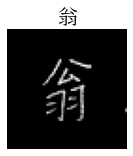

In [5]:
show_image(sample_img[200], sample_lable[200])
# free again
del(sample_img)
del(sample_lable)

Now load all samples which are Kanji characters.

In [6]:
#x, y =  reader.read_dataset_part(ETLDataNames.ETL9, [ETLCharacterGroups.kanji], 16)    # load only a part for testing
parts = [ETLCharacterGroups.kanji, ETLCharacterGroups.katakana, ETLCharacterGroups.hiragana,
    ETLCharacterGroups.roman, ETLCharacterGroups.number]
x, y = reader.read_dataset_whole(parts, 16)
print(x.shape, y.shape)

100%|██████████| 127/127 [00:53<00:00,  2.35it/s]
(1854854, 64, 64, 1) (1854854,)


With the loaded data we can take a look at the class distributions.

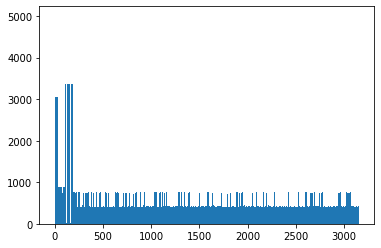

In [7]:
unique, counts = np.unique(y, return_counts=True)
balance = dict(zip(unique, counts))

plt.bar(range(0, len(counts)), counts, width=1.0)
plt.show()

In [8]:
def generate_images(amount : int, kanji : str, fonts : [str]):
    """

    Args:
        amount : 
        kanji  : 
        fonts  : 
    """

    cnt = 0
    kanji_labels = np.full(shape=(amount), fill_value=kanji, dtype=str)
    kanji_imgs = np.zeros(shape=(amount, 64, 64, 1), dtype=np.uint8)

    while amount > cnt:
        # for every given font
        for f in fonts:

            if (cnt >= amount):
                break

            font_size = 50
            font = ImageFont.truetype(f, font_size)
                
            # make sure that the image fits in the 64x64 image
            if(font.getsize(kanji)[0] > 64):
                font = ImageFont.truetype(f, font_size - (font.getsize(kanji)[0] - font_size))
            if(font.getsize(kanji)[1] > 64):
                font = ImageFont.truetype(f, font_size - (font.getsize(kanji)[1] - font_size))

            # create the image
            img = PImage.new(mode="L", size=(64, 64), color=0)
            d = ImageDraw.Draw(img)
            d.text(((64 - font.getsize(kanji)[0]) // 4, (64 - font.getsize(kanji)[1]) // 4), kanji, font=font, fill=255)     

            # store the image in the array
            kanji_imgs[cnt] = np.array(img).reshape(64, 64, 1)
            if(cnt+1 < amount):
                kanji_imgs[cnt+1] = np.array(distort_sample(img)[0]).reshape(64, 64, 1)
            
            cnt += 2

    return kanji_imgs, kanji_labels

In [10]:
def distort_sample(img : PImage) -> [PImage, [int], [int]]:
    """
    Distort the given image randomly.

    Randomly applies the transformations:
        rotation, shear, scale, translate, 
    Randomly applies the filter:
        sharpen, blur, smooth

    Returns the distorted image.
    """

    offset, scale = (0, 0), (64, 64)

    t = random.choice(["sine", "rotate", "shear"])
    f = random.choice(["blur", "sharpen", "smooth"])

    # randomly apply transformations...
    # rotate image
    if("rotate" in t):
        img = img.rotate(random.uniform(-30, 30))
    
    # shear image
    if("shear" in t):
        y_shear = random.uniform(-0.2, 0.2)
        x_shear = random.uniform(-0.2, 0.2)
        img = img.transform(img.size, PImage.AFFINE, (1, x_shear, 0, y_shear, 1, 0))
    
    # scale and translate image
    if(True):
        #scale the image
        size_x = random.randrange(25, 63)
        size_y = random.randrange(25, 63)
        scale = (size_x, size_y)
        offset = (math.ceil((64 - size_x) / 2), math.ceil((64 - size_y) / 2))
        img = img.resize(scale)

        # put it again on a black background (translated)
        background = PImage.new('L', (64, 64))
        trans_x = random.randrange(0, math.floor((64 - size_x)))
        trans_y = random.randrange(0, math.floor((64 - size_y)))
        offset = (trans_x, trans_y)
        background.paste(img, offset)
        img = background
    
    if("sine" in t):
        t_img = np.array(img)

        A = t_img.shape[0] / 3.0
        w = 2.0 / t_img.shape[1]

        shift_factor = random.choice([-1, 1]) * random.uniform(0.15, 0.2)
        shift = lambda x: shift_factor * A * np.sin(-2*np.pi*x * w)

        for i in range(t_img.shape[0]):
            t_img[:,i] = np.roll(t_img[:,i], int(shift(i)))

        img = PImage.fromarray(t_img)


    # blur
    if("blur" in f):
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.2)))

    # sharpen
    if("sharpen" in f):
        img = img.filter(ImageFilter.SHARPEN)
        
    # smooth
    if("smooth" in f):
        img = img.filter(ImageFilter.SMOOTH)

    return img, offset, scale

The classes are very imbalanced therefore let's enrich the data with augmented samples.

In [12]:
# the desired number of samples
num_samples = 1000

augmented_imgs, augmented_labels = [x], [y]

fonts = [os.path.join(os.path.dirname(os.getcwd()), "fonts", i) for i in os.listdir(os.path.join("..", "fonts"))]

start = time.perf_counter()
with tqdm(total=len(unique)) as pbar:
    for key, value in balance.items():
        # if there are less than desired samples
        if(value < num_samples):
            to_generate = num_samples - value
            augmented_x, augmented_y = generate_images(to_generate, key, fonts)
            
            augmented_imgs.append(augmented_x)
            augmented_labels.append(augmented_y)

        # if there are more than desired samples
        elif(value > num_samples):
            pass

        pbar.update(1)

print("elapsed time:", time.perf_counter() - start

100%|██████████| 3155/3155 [19:00<00:00,  2.77it/s]


In [16]:
x = np.concatenate(augmented_imgs)
y = np.concatenate(augmented_labels)
gc.collect()

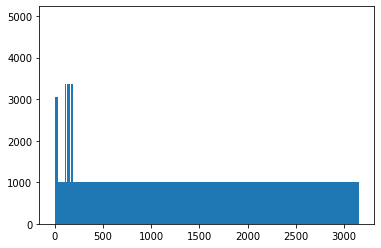

In [17]:
unique, counts = np.unique(y, return_counts=True)
balance = dict(zip(unique, counts))

plt.bar(range(0, len(counts)), counts, width=1.0)
plt.show()

### Save images and augmented images to disk 

In [41]:
    def save_to_file(x : np.ndarray, y : np.ndarray, save_to : str):
        """
        Saves all images and labels to file.

        Warning:
            Throws an FileNotFoundError if the path to save the images to is not valid.

        Args:
            x       : a numpy array containing all images.
            y       : a numpy array containing all labels.
            save_to : the path to the folder where the image and labels should be saved
                      for each label in `y` a directory will be created.
        """
    
        if(save_to != ""):
            if(os.path.isdir(save_to)):
                
                start = time.perf_counter()

                # create folders for all labels
                unique_labels = np.unique(y)
                for i in unique_labels:
                    if(not os.path.isdir(os.path.join(save_to, i))):
                        os.mkdir(os.path.join(save_to, i))

                # start counting every class from 0
                img_counts = {label : 0 for label in unique_labels}

                # save all images to the matching folders
                with tqdm(total=len(x)) as pbar:
                    for cnt, img in enumerate(x):
                        # image was normalized between [0, 1]
                        if(img.max() == 1)
                            p_img = ((img * 255).astype(np.uint8)).reshape(img.shape[0], img.shape[1])
                        # image was not normalized [0, 255]
                        else:
                            p_img = (img.astype(np.uint8)).reshape(img.shape[0], img.shape[1])

                        p_img = PImage.fromarray(p_img, mode="L")
                        
                        p_img.save(os.path.join(save_to, y[cnt], str(img_counts[y[cnt]]) + ".jpg"))
                        img_counts[y[cnt]] += 1

                        pbar.update(1)

                print("Saved in:", time.perf_counter() - start)

            else:
                raise FileNotFoundError("The given path:", save_to, "is not a valid directory.")

In [42]:
save_to_file(x, y, r"F:\data_sets\etlcdb")

100%|██████████| 3343099/3343099 [24:12<00:00, 2301.65it/s]Saved in: 1452.7642119999996



## Create images for missing JIS-2 Kanji

### Save JIS-2 images to disk